In [2]:
import numpy as np
import ipywidgets as widgets
from matplotlib import pyplot as plt
from IPython.display import display, HTML

from utils import *

In [3]:
x_points, y_points, line_segments = track_example4()

# Linear Trajectory

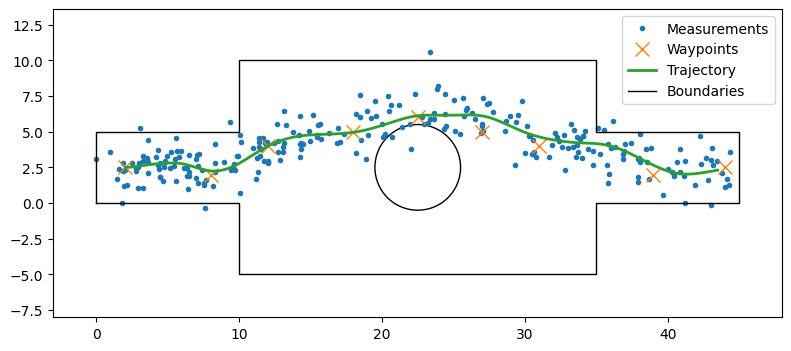

In [4]:
trajectory_linear = MPCTrajectory(x_points, y_points, line_segments, linearity='linear', savepath="output/track_4_linear.pkl")
states, measurements = trajectory_linear.get_data()

circle = plt.Circle((22.5, 2.5), 3, color='k', fill=False)
trajectory_linear.plot(extra=circle)

In [5]:
show_animation(trajectory_linear, gif_path="animations/car_trajectory_dynopt")

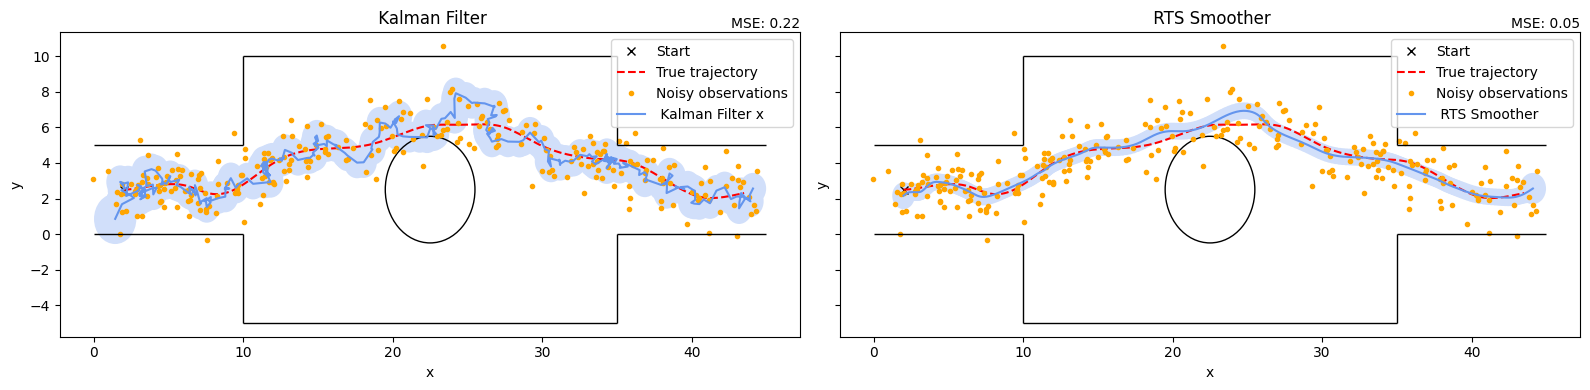

In [6]:
system = StateSpaceModel()

kalman_filter = KF(system.A, system.Q, system.H, system.R)
state_estimates, cov_estimates = kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, extra=circle) # remember that circle is also hard coded in the function

In [7]:
kalman_animation_path = "animations/kalman_filter_dynopt"
kalman_animation = PlotAnimation(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name=kalman_animation_path)

show_filter_animation(kalman_animation, kalman_animation_path)

In [10]:
from utils.dynopt import kalman_casadi_opt_linear

casadi_states, casadi_q, casadi_r = kalman_casadi_opt_linear(states, measurements, system.A, system.Q, system.H, system.R)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9088
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3474

Total number of variables............................:     2676
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1604
Total number of inequality c

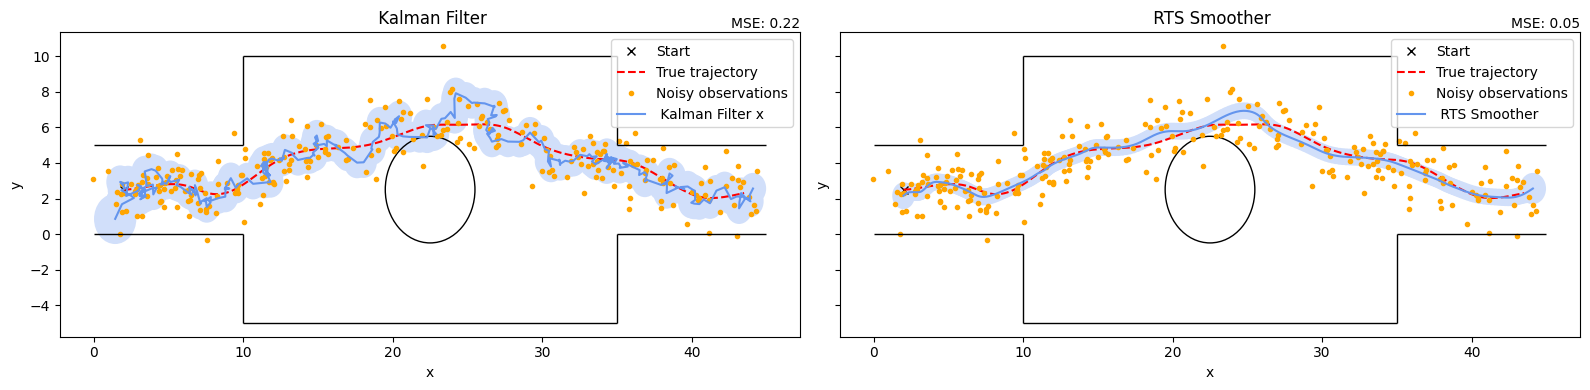

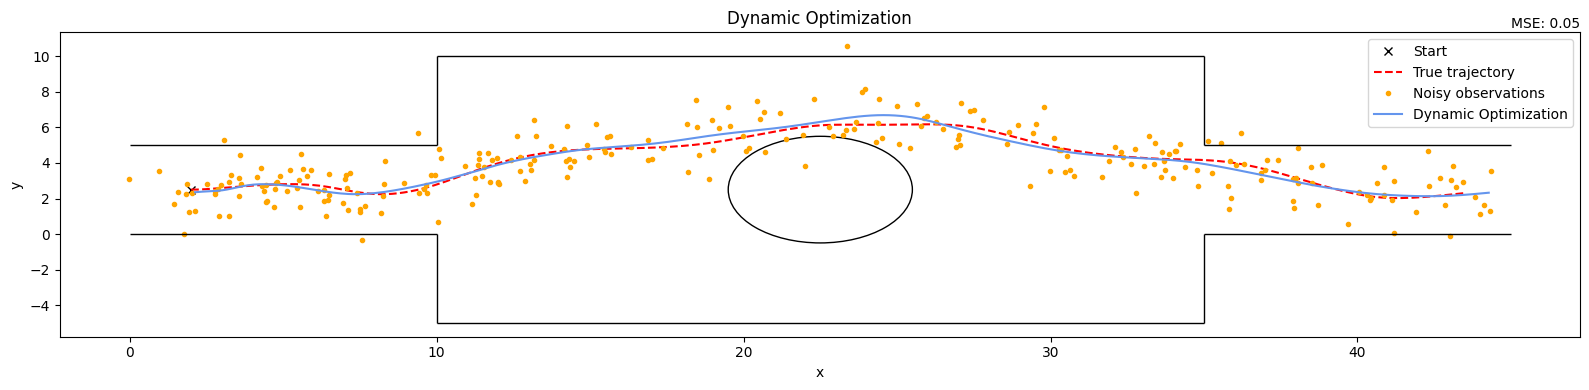

In [11]:
zero_cov = np.zeros((states.shape[0], states.shape[1], states.shape[1]))

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, extra=circle)
visualize_filter(states, measurements, casadi_states.T, zero_cov, extra=circle, title="Dynamic Optimization")

# Nonlinear

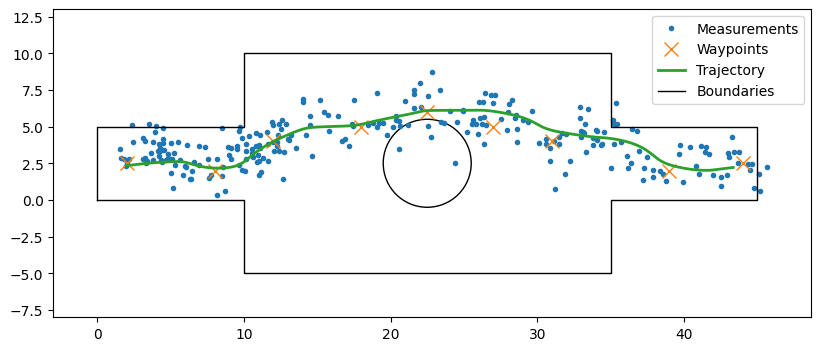

In [13]:
trajectory_nonlinear = MPCTrajectory(x_points, y_points, line_segments, linearity='nonlinear', savepath="output/track_4_nonlinear.pkl")
states, measurements = trajectory_nonlinear.get_data()

circle = plt.Circle((22.5, 2.5), 3, color='k', fill=False)
trajectory_linear.plot(extra=circle)

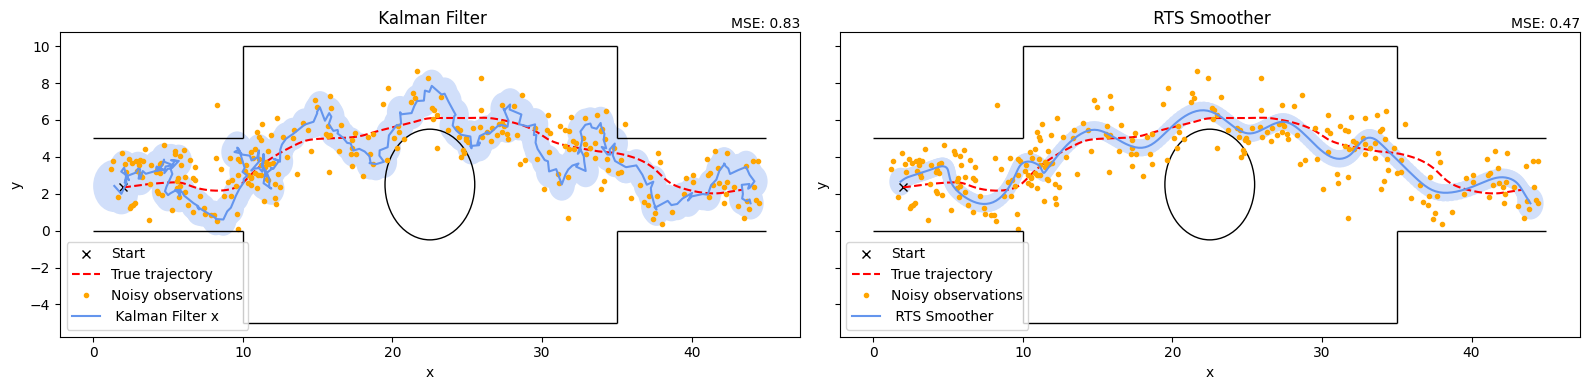

In [14]:
system = StateSpaceModel()

kalman_filter = KF(system.A, system.Q, system.H, system.R)
state_estimates, cov_estimates = kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, extra=circle)

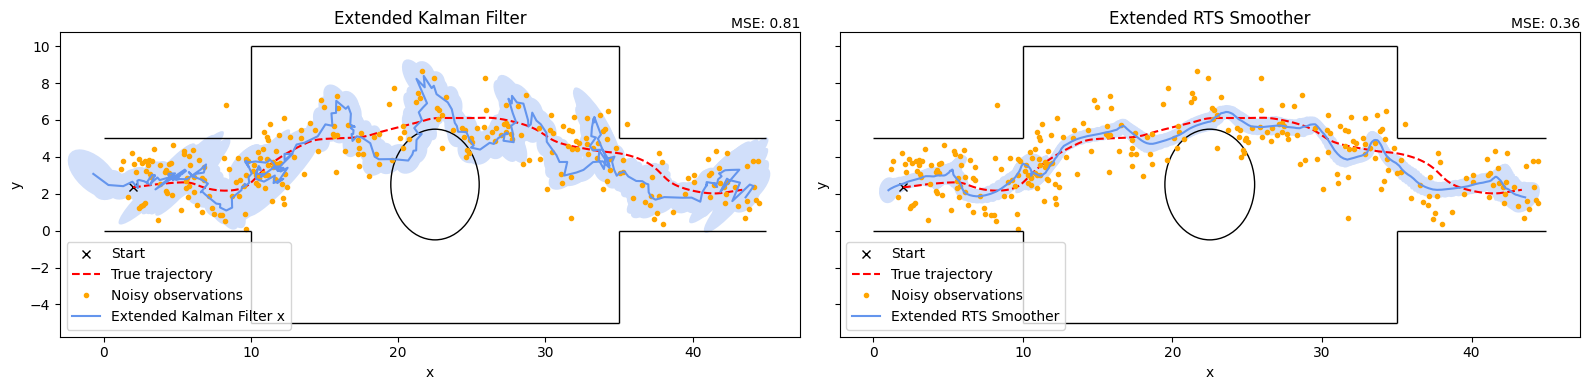

In [15]:
extendted_kalman_filter = EKF(system.f, system.F_jacobian, system.h, system.H_jacobian, system.Q, system.R)
state_estimates, cov_estimates = extendted_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = extendted_kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant="Extended", extra=circle)

In [17]:
from utils.dynopt import kalman_casadi_opt_nonlinear

casadi_states_linear, casadi_q_linear, casadi_r_linear = kalman_casadi_opt_linear(states, measurements, system.A, system.Q, system.H, system.R)
casadi_states_nonlinear, casadi_q_nonlinear, casadi_r_nonlinear = kalman_casadi_opt_nonlinear(states, measurements, system.f, system.h, system.Q, system.R)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9088
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3474

Total number of variables............................:     2676
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1604
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.45e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

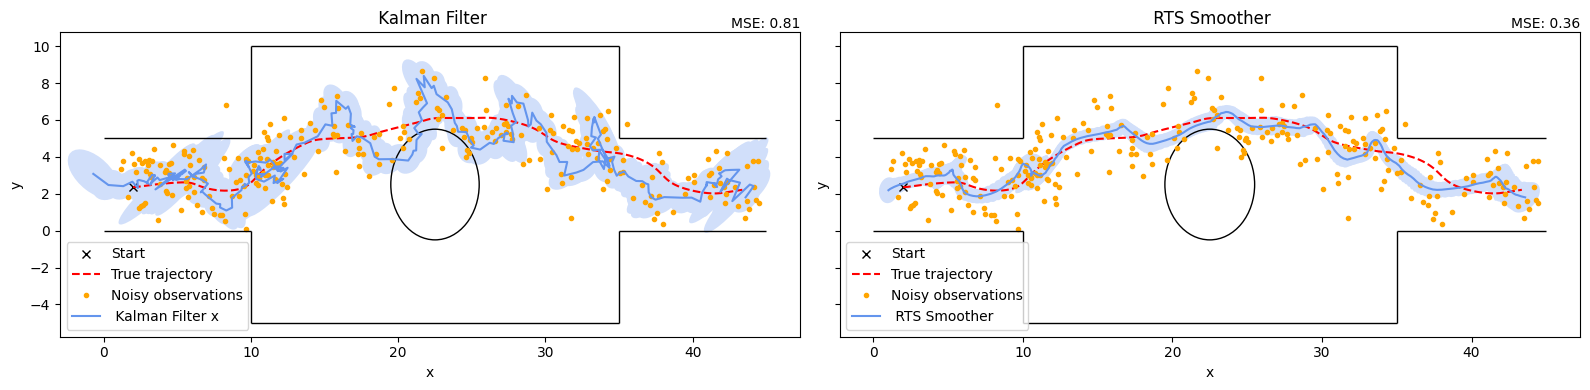

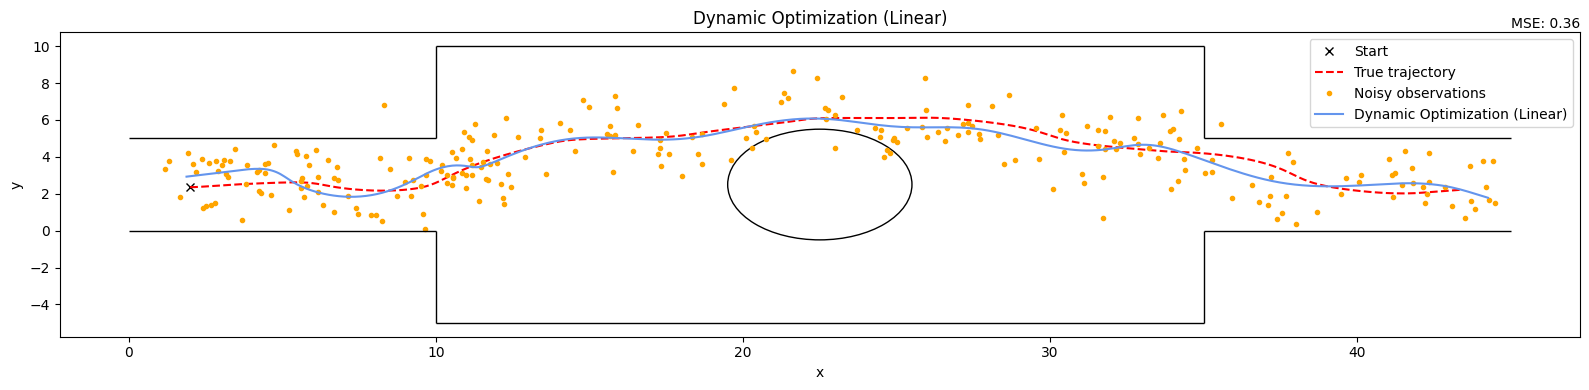

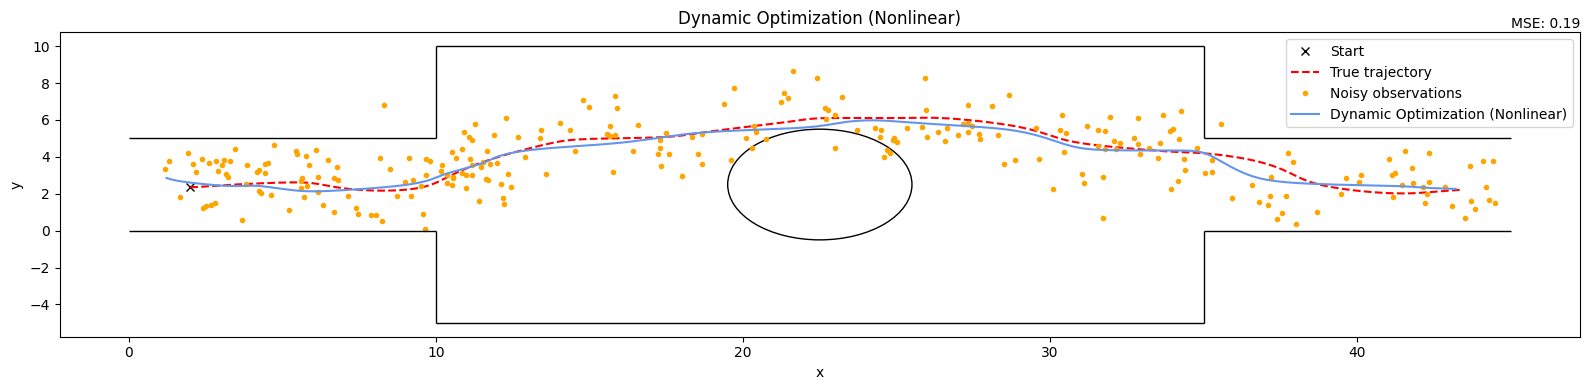

In [18]:
zero_cov = np.zeros((states.shape[0], states.shape[1], states.shape[1]))

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, extra=circle)
visualize_filter(states, measurements, casadi_states_linear.T, zero_cov, extra=circle, title="Dynamic Optimization (Linear)")
visualize_filter(states, measurements, casadi_states_nonlinear.T, zero_cov, extra=circle, title="Dynamic Optimization (Nonlinear)")

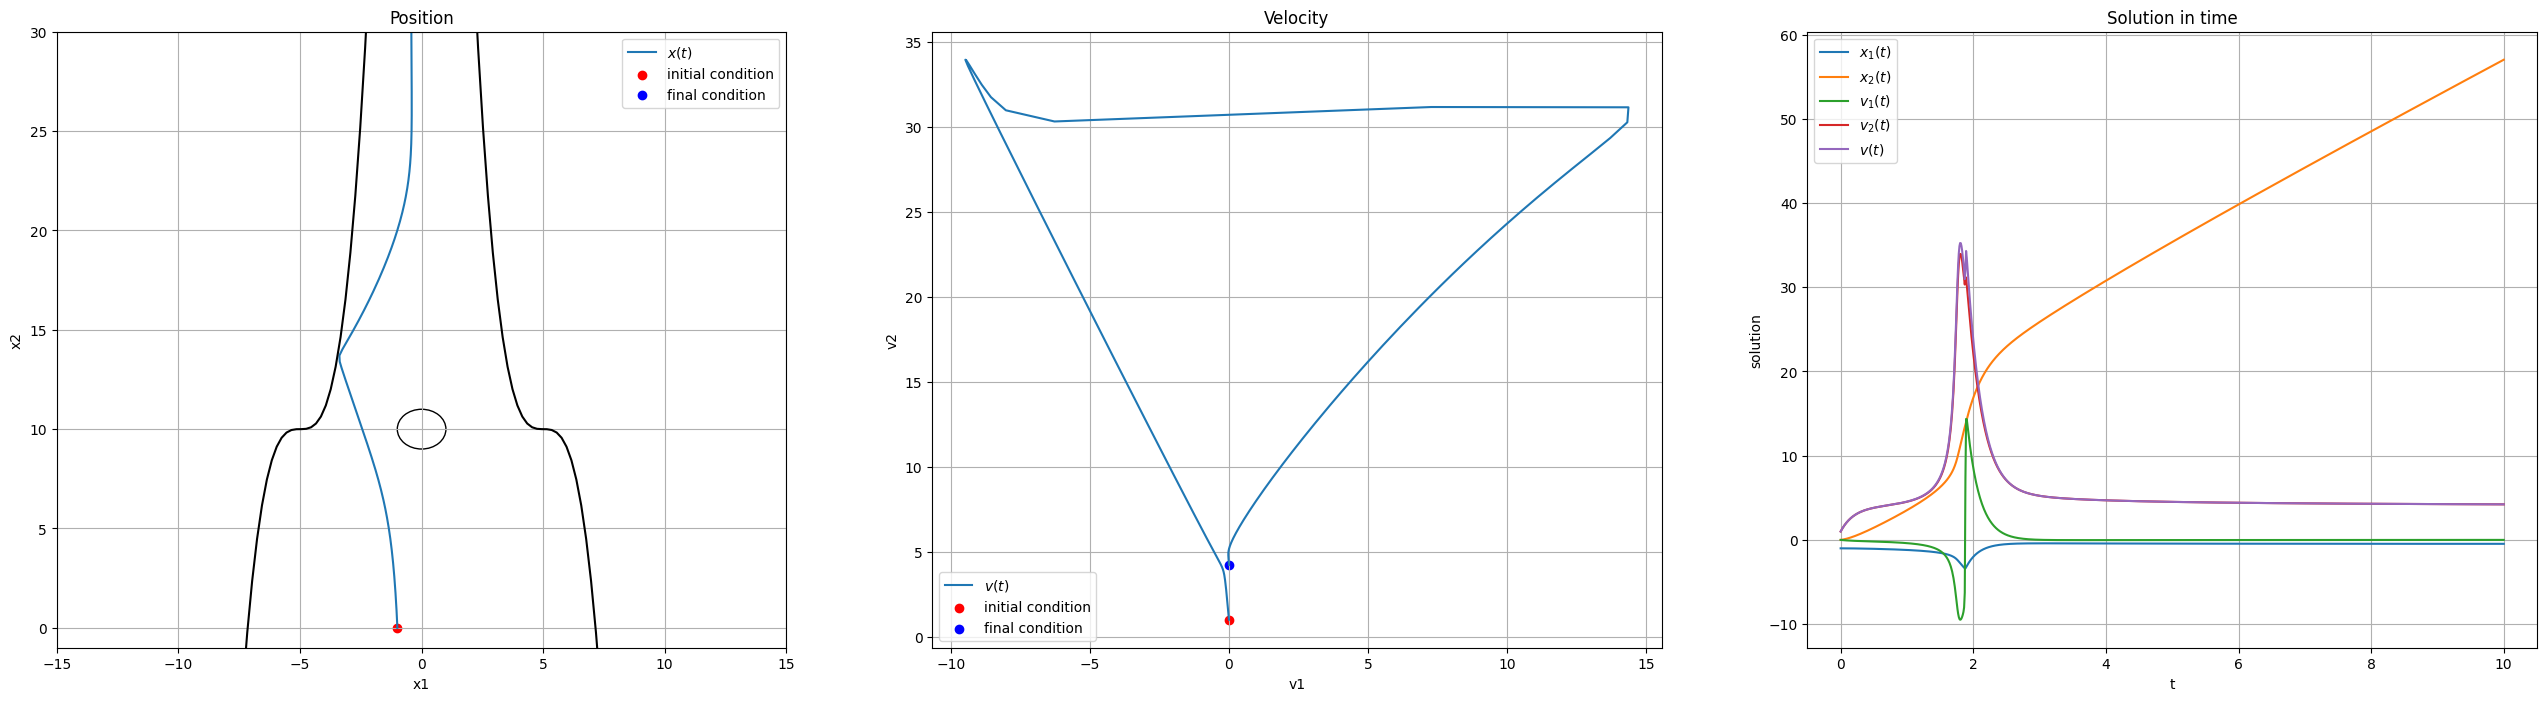

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def plot_solution(solution, center, radius):
    # Plot the results
    fig, ax = plt.subplots(1, 3, figsize=(32, 8))


    ax[0].plot(solution.y[0], solution.y[1], label='$x(t)$')
    ax[0].scatter(solution.y[0][0], solution.y[1][0], label='initial condition', color='red') # plot initial condition
    ax[0].scatter(solution.y[0][-1], solution.y[1][-1], label='final condition', color='blue') # plot final condition

    circle = plt.Circle((center[0], center[1]), radius, color='k', fill=False)
    ax[0].add_artist(circle)

    def g(x, w1=w1, w2=w2):
        return w1+(x+w2)**3
    
    def g2(x, w1=w1, w2=w2):
        return w1+(-x+w2)**3

    ax[0].plot(np.linspace(-10, 10, 100), [g(x) for x in np.linspace(-10, 10, 100)], color='k')
    ax[0].plot(np.linspace(-10, 10, 100), [g2(x) for x in np.linspace(-10, 10, 100)], color='k')

    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[0].set_title('Position')

    ax[0].set_xlim([-15, 15])
    ax[0].set_ylim([-1, 30])

    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(solution.y[2], solution.y[3], label='$v(t)$')
    ax[1].scatter(solution.y[2][0], solution.y[3][0], label='initial condition', color='red') # plot initial condition
    ax[1].scatter(solution.y[2][-1], solution.y[3][-1], label='final condition', color='blue') # plot final condition

    ax[1].set_xlabel('v1')
    ax[1].set_ylabel('v2')
    ax[1].set_title('Velocity')

    ax[1].grid(True)
    ax[1].legend()

    ax[2].plot(solution.t, solution.y[0], label='$x_1(t)$')
    ax[2].plot(solution.t, solution.y[1], label='$x_2(t)$')
    ax[2].plot(solution.t, solution.y[2], label='$v_1(t)$')
    ax[2].plot(solution.t, solution.y[3], label='$v_2(t)$')

    velocity = np.sqrt(solution.y[2]**2 + solution.y[3]**2)
    ax[2].plot(solution.t, velocity, label='$v(t)$')

    ax[2].set_xlabel('t')
    ax[2].set_ylabel('solution')
    ax[2].set_title('Solution in time')

    ax[2].grid(True)
    ax[2].legend()

    plt.show()

# Define the system of coupled ODEs for 4 dimensions
def system(t, y):
    x1, x2, v1, v2 = y

    #u = -x2
    #du_dx1 = 0
    #du_dx2 = -1

    #u = (np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**-1 - x2
    #du_dx1 = -((2*x1 - radius) / ((np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**3)*np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)) 
    #du_dx2 = -((2*x2 - radius) / ((np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**3)*np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)) - 1

    # u = (np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**-1 - s*x2 + (-w1 + x2 - (x1+w2)**3)**-2

    du_dx1 = -((2*x1 - radius) / ((np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**3)*np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)) + 6 * (x1+w2)**2 / (-w1 + x2 - (x1+w2)**3)**3 + 6 * (x1-w2)**2 / (w1 + x2 - (x1-w2)**3)**3
    du_dx2 = -((2*x2 - radius) / ((np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**3)*np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)) - s + 2 / (-w1 + x2 - (x1+w2)**3)**3 + 2 / (w1 + x2 - (x1-w2)**3)**3

    dx1_dt = v1
    dx2_dt = v2
    dv1_dt = -c*du_dx1 - l * v1
    dv2_dt = -c*du_dx2 - l * v2

    return [dx1_dt, dx2_dt, dv1_dt, dv2_dt]

# Set the initial conditions
#initial_conditions = [0, 0, 0, 16]
initial_conditions = [-1, 0, 0, 1]

# Set the time span
t_max = 10
t_span = (0, t_max)

center = np.array([0, 10])
radius = 1

w1, w2 = 10, 5

l = 5 # friction
s = 1 # slope
c = 20


# r = 1, l = 1, s = 1, w1 = 10, w2 = 5, x1=-1, v2=2, t_max=10 -> pretty cool solution
# Solve the ODEs
solution = solve_ivp(system, t_span, initial_conditions, t_eval=np.linspace(t_span[0], t_span[1], 1000), atol=1e-8, rtol=1e-8)

plot_solution(solution, center, radius)

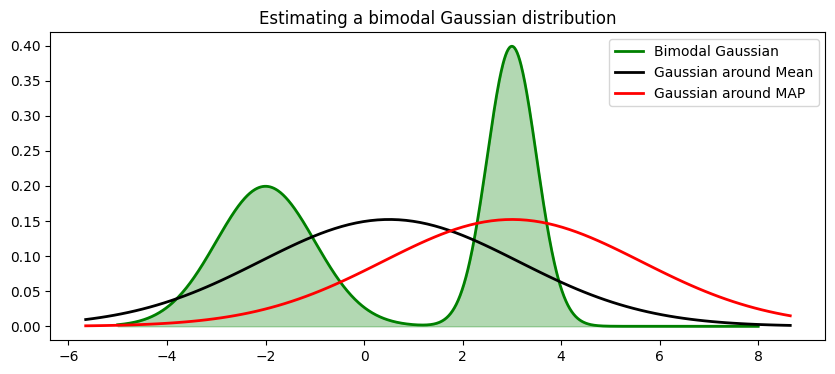

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Generate data for a bimodal Gaussian distribution
np.random.seed(42)
data = np.concatenate([np.random.normal(-2, 1, 500), np.random.normal(3, 0.5, 500)])

# Fit a Gaussian distribution to the data
mu, std = norm.fit(data)

# Compute the MAP estimate (Laplace approximation)
bimodal_pdf = lambda x: 0.5 * norm.pdf(x, -2, 1) + 0.5 * norm.pdf(x, 3, 0.5)
mode_estimate = np.argmax(bimodal_pdf(np.linspace(-5, 8, 1000)))
map_estimate = np.linspace(-5, 8, 1000)[mode_estimate]

# Plot the bimodal Gaussian distribution
# Plot the bimodal Gaussian distribution outline
x = np.linspace(-5, 8, 1000)
y = bimodal_pdf(x)
plt.plot(x, y, 'g', linewidth=2, label='Bimodal Gaussian')
plt.fill_between(x, y, color='g', alpha=0.3)

# Plot Gaussian around the mean
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2, label='Gaussian around Mean')

# Plot Gaussian around the MAP estimate (Laplace approximation)
p_map = norm.pdf(x, map_estimate, std)
ax.plot(x, p_map, 'r', linewidth=2, label='Gaussian around MAP')

plt.title('Estimating a bimodal Gaussian distribution')
plt.legend()
plt.show()
